In [32]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [2]:
paviaU = scipy.io.loadmat('./PaviaU.mat')['paviaU']
paviaU_gt = scipy.io.loadmat('./PaviaU_gt.mat')['paviaU_gt']

In [3]:
Nmax = paviaU.max()
paviaU = (paviaU/Nmax).astype(np.float32)

In [4]:
paviaU = paviaU.reshape(610*340, 103)

In [50]:
pca = PCA(10)
paviaU_PCA = pca.fit_transform(paviaU)

In [51]:
mms = MinMaxScaler()
paviaU_PCA = mms.fit_transform(paviaU_PCA)

In [52]:
def getiim(size,band):
    hf = int(size/2)
    aa = np.zeros(((610*340),size,size,band))
    a = np.zeros((610+size, 340+size, band))
    a[hf:-hf,hf:-hf,:] = paviaU_PCA.reshape((610,340,band))
    count = 0
    output = []
    for i in range(size,610-1):
        for j in range(size,340-1):
            #print(i,j)
            aa[count] = a[i-hf:i+hf,j-hf:j+hf,:]
            #print(count)
            count = count+1
    return aa

In [53]:
data_im = getiim(4,10)

In [54]:
data_im.shape

(207400, 4, 4, 10)

In [55]:
X = data_im
y = paviaU_gt.reshape(207400)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
nsplit = int(0.2*len(paviaU_PCA))
X_train = X[:nsplit]
y_train = y[:nsplit]
X_val = X[nsplit:nsplit*2]
y_val = y[nsplit:nsplit*2]
X_test = X[nsplit*2:]
y_test = y[nsplit*2:]
X,y = None,None

In [56]:
y_train_encode = keras.utils.to_categorical(y_train)
y_val_encode = keras.utils.to_categorical(y_val)
y_test_encode = keras.utils.to_categorical(y_test)


In [57]:
def nnmodel(input_shape):
    X_input = keras.layers.Input((input_shape))
    X = keras.layers.Flatten()(X_input)
    X = keras.layers.Dense(2048,activation='sigmoid')(X)
    X = keras.layers.Dense(512,activation='sigmoid')(X)
    X = keras.layers.Dense(512,activation='sigmoid')(X)
    X = keras.layers.Dense(10,activation='softmax')(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='model')
    return model

In [58]:
mymodel = nnmodel(X_train[0].shape)
mymodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
mymodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4, 4, 10)]        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2048)              329728    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 10)                5130      
Total params: 1,646,602
Trainable params: 1,646,602
Non-trainable params: 0
___________________________________________________

In [59]:
mymodel.fit(X_train,y_train_encode,batch_size=256,epochs=20,validation_data=(X_val,y_val_encode))

Train on 41480 samples, validate on 41480 samples
Epoch 1/20
41480/41480 [==============================] - 1s 27us/sample - loss: 0.8958 - accuracy: 0.7892 - val_loss: 0.8359 - val_accuracy: 0.8099
Epoch 2/20
41480/41480 [==============================] - 1s 15us/sample - loss: 0.8503 - accuracy: 0.8061 - val_loss: 0.8331 - val_accuracy: 0.8099
Epoch 3/20
41480/41480 [==============================] - 1s 15us/sample - loss: 0.8492 - accuracy: 0.8064 - val_loss: 0.8354 - val_accuracy: 0.8099
Epoch 4/20
41480/41480 [==============================] - 1s 15us/sample - loss: 0.8471 - accuracy: 0.8064 - val_loss: 0.8393 - val_accuracy: 0.8099
Epoch 5/20
41480/41480 [==============================] - 1s 15us/sample - loss: 0.8438 - accuracy: 0.8064 - val_loss: 0.8198 - val_accuracy: 0.8099
Epoch 6/20
41480/41480 [==============================] - 1s 15us/sample - loss: 0.8390 - accuracy: 0.8064 - val_loss: 0.8196 - val_accuracy: 0.8099
Epoch 7/20
41480/41480 [==============================] 

KeyboardInterrupt: 

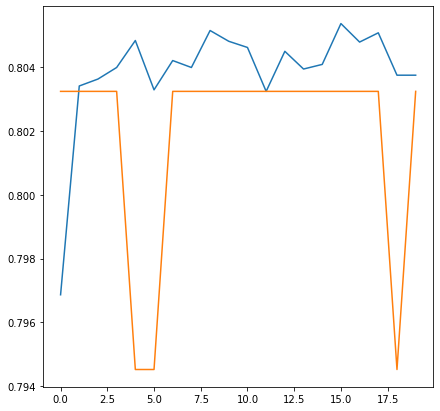

In [49]:
his = mymodel.history.history
plt.figure(figsize=(7,7))
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
#plt.savefig('ovf100ep.png')

In [30]:
#mymodel.save('ovf100ep.h5')

In [31]:
print(classification_report(y_test,np.argmax(mymodel.predict(X_test),axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     98815
           1       0.19      0.06      0.09      3991
           2       0.49      0.62      0.55     11155
           3       0.30      0.12      0.17      1220
           4       0.15      0.06      0.09      1826
           5       0.21      0.13      0.16       783
           6       0.55      0.47      0.51      3029
           7       0.32      0.14      0.19       804
           8       0.30      0.11      0.16      2251
           9       0.09      0.07      0.08       566

    accuracy                           0.79    124440
   macro avg       0.34      0.27      0.29    124440
weighted avg       0.76      0.79      0.77    124440



In [120]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = mymodel(input_image)
        loss = loss_object(input_label, prediction)

      # Get the gradients of the loss w.r.t to the input image.
        gradient = tape.gradient(loss, input_image)
      # Get the sign of the gradients to create the perturbation
        signed_grad = tf.sign(gradient)
    return signed_grad

In [134]:
pn = create_adversarial_pattern(tf.convert_to_tensor(X_train),tf.convert_to_tensor(y_train_encode))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


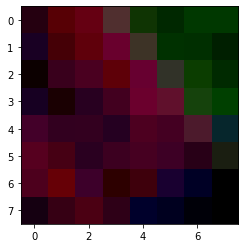

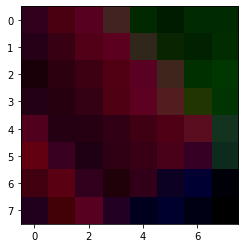

In [135]:
plt.imshow(X_val[400,:]+0.05*pn[400,:])
plt.figure()
plt.imshow(X_val[400,:])

In [129]:
pn.shape

TensorShape([41480, 8, 8, 3])

In [136]:
xatk = X_train+0.1*pn

In [137]:
mymodel.evaluate(xatk,y_train_encode)

41480/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[6.364060802147037, 0.52205884]

In [132]:
mymodel.evaluate(X_val,y_val_encode)

41480/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.1716475160165603, 0.77675986]

In [143]:
print(classification_report(y_train,np.argmax(mymodel.predict(xatk),axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     32804
           1       0.65      0.25      0.36      1370
           2       0.75      0.85      0.80      3731
           3       0.89      0.25      0.39       474
           4       0.90      0.13      0.22       603
           5       0.90      0.15      0.26       284
           6       0.71      0.55      0.62      1010
           7       0.87      0.24      0.37       275
           8       0.78      0.10      0.17       736
           9       0.88      0.08      0.14       193

    accuracy                           0.89     41480
   macro avg       0.83      0.36      0.43     41480
weighted avg       0.88      0.89      0.87     41480



In [142]:
print(classification_report(y_train,np.argmax(mymodel.predict(X_train),axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87     32804
           1       0.39      0.11      0.18      1370
           2       0.31      0.26      0.28      3731
           3       0.72      0.20      0.32       474
           4       0.75      0.06      0.12       603
           5       0.84      0.13      0.23       284
           6       0.47      0.44      0.45      1010
           7       0.82      0.20      0.32       275
           8       0.56      0.08      0.14       736
           9       0.89      0.04      0.08       193

    accuracy                           0.78     41480
   macro avg       0.66      0.25      0.30     41480
weighted avg       0.75      0.78      0.75     41480



In [141]:
mymodel.fit(xatk,y_train_encode,batch_size=32,epochs=10,validation_data=(X_val,y_val_encode))

Train on 41480 samples, validate on 41480 samples
Epoch 1/10
41480/41480 [==============================] - 8s 200us/sample - loss: 0.9060 - accuracy: 0.8131 - val_loss: 0.8210 - val_accuracy: 0.7971
Epoch 2/10
41480/41480 [==============================] - 8s 199us/sample - loss: 0.7261 - accuracy: 0.8190 - val_loss: 0.8551 - val_accuracy: 0.7942
Epoch 3/10
41480/41480 [==============================] - 8s 200us/sample - loss: 0.6647 - accuracy: 0.8300 - val_loss: 0.8567 - val_accuracy: 0.7904
Epoch 4/10
41480/41480 [==============================] - 8s 201us/sample - loss: 0.6128 - accuracy: 0.8408 - val_loss: 0.9249 - val_accuracy: 0.7900
Epoch 5/10
41480/41480 [==============================] - 8s 199us/sample - loss: 0.5754 - accuracy: 0.8471 - val_loss: 0.8858 - val_accuracy: 0.7898
Epoch 6/10
41480/41480 [==============================] - 8s 195us/sample - loss: 0.5355 - accuracy: 0.8545 - val_loss: 0.9380 - val_accuracy: 0.7813
Epoch 7/10
41480/41480 [==========================

In [144]:
print(classification_report(y_test,np.argmax(mymodel.predict(X_test),axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85     98764
           1       0.07      0.02      0.03      3949
           2       0.19      0.15      0.17     11205
           3       0.08      0.01      0.02      1237
           4       0.11      0.00      0.01      1862
           5       0.20      0.02      0.03       796
           6       0.23      0.16      0.19      3036
           7       0.20      0.02      0.03       795
           8       0.08      0.01      0.01      2218
           9       0.13      0.00      0.01       578

    accuracy                           0.74    124440
   macro avg       0.21      0.13      0.14    124440
weighted avg       0.67      0.74      0.70    124440

